In [4]:
# import api keys
from api_keys import *

## Flights API

In [ ]:
from datetime import datetime, timedelta

airport_icoa = "EDDB"
to_local_time = datetime.now().strftime('%Y-%m-%dT%H:00')
from_local_time = (datetime.now() + timedelta(hours=9)).strftime('%Y-%m-%dT%H:00')
url = f"https://aerodatabox.p.rapidapi.com/flights/airports/icao/{airport_icoa}/{to_local_time}/{from_local_time}"


import requests

querystring = {"withLeg":"true","withCancelled":"true","withCodeshared":"true","withCargo":"true","withPrivate":"false","withLocation":"false"}

headers = {
    'x-rapidapi-host': "aerodatabox.p.rapidapi.com",
    'x-rapidapi-key': flight_api_key
    }

response = requests.request("GET", url, headers=headers, params=querystring)

from IPython.display import JSON
response.json()

In [ ]:
### Option 1
arrivals_berlin = response.json()['arrivals']

def get_flight_info(flight_json):
    # terminal
    try: terminal = flight_json['arrival']['terminal']
    except: terminal = None
    # aircraft
    try: aircraft = flight_json['aircraft']['model']
    except: aircraft = None

    return {
        'dep_airport':flight_json['departure']['airport']['name'],
        'sched_arr_loc_time':flight_json['arrival']['scheduledTimeLocal'],
        'terminal':terminal,
        'status':flight_json['status'],
        'aircraft':aircraft,
        'icao_code':airport_icoa
    }


import pandas as pd
# [get_flight_info(flight) for flight in arrivals_berlin]
arrivals_berlin = pd.DataFrame([get_flight_info(flight) for flight in arrivals_berlin])
arrivals_berlin

In [ ]:
### Option 2
import pandas as pd
arrivals = pd.json_normalize(response.json()['arrivals'])
# next step: select the columns you want to incude on your database
(
arrivals
    .filter(['departure.airport.name','arrival.scheduledTimeLocal',
             'arrival.terminal','status','aircraft.model'])
    .assign(icao_code = airport_icoa)
)

## Wheather API

### Using `pyowm` library

In [ ]:
!pip install pyowm 
from pyowm import OWM
from pyowm.utils import config
from pyowm.utils import timestamps
import pandas as pd

city = "Berlin"
country = "DE"

owm = OWM(OWM_key)
mgr = owm.weather_manager()

# Will it be clear tomorrow at this time in Milan (Italy) ?
forecast = mgr.forecast_at_place(city + ',' + country, '3h')
# answer = forecast.will_be_clear_at(timestamps.tomorrow())

from numpy import nan

def forecast_extraction(forecast_object): 
    """
    Given a forecast object from Open weathor Pyhton API, 
    return a structured dataframe. 

    :param: forecast object
    :returns: a dataframe with specific weather information
    """
    forecast_df = pd.json_normalize({
        'time' : forecast_object.reference_time(timeformat='date'), 
        'temperature' : forecast_object.temperature(unit='celsius'), 
        'precipitation_probabily' : forecast_object.precipitation_probability, 
        'rain' : forecast_object.rain, 
        'humidity' : forecast_object.humidity, 
        'status' : forecast_object.status, 
        'snow' : [nan if forecast_object.snow is None else forecast_object.snow], 
        'wind' : forecast_object.wind('km_hour')
    })

    return(forecast_df)

weather_forecast = pd.concat(
    [forecast_extraction(weather) for weather in forecast.forecast.weathers]
)

weather_forecast.head()

### Connecting to OWM API

In [ ]:
# achieve the same result with the wather api
response = requests.get(f'http://api.openweathermap.org/data/2.5/forecast/?q={city},{country}&appid={OWM_key}&units=metric&lang=en')

from IPython.display import JSON
JSON(response.json())


In [ ]:
forecast_api = response.json()['list']
# look for the fields that could ve relevant: 
# better field descriptions https://www.weatherbit.io/api/weather-forecast-5-day

weather_info = []

# datetime, temperature, wind, prob_perc, rain_qty, snow = [], [], [], [], [], []
for forecast_3h in forecast_api: 
    weather_hour = {}
    # datetime utc
    weather_hour['datetime'] = forecast_3h['dt_txt']
    # temperature 
    weather_hour['temperature'] = forecast_3h['main']['temp']
    # wind
    weather_hour['wind'] = forecast_3h['wind']['speed']
    # probability precipitation 
    try: weather_hour['prob_perc'] = float(forecast_3h['pop'])
    except: weather_hour['prob_perc'] = 0
    # rain
    try: weather_hour['rain_qty'] = float(forecast_3h['rain']['3h'])
    except: weather_hour['rain_qty'] = 0
    # wind 
    try: weather_hour['snow'] = float(forecast_3h['snow']['3h'])
    except: weather_hour['snow'] = 0
    weather_hour['municipality_iso_country'] = city + ',' + country
    weather_info.append(weather_hour)
    
weather_data = pd.DataFrame(weather_info)
weather_data.head()

## Population data

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import unicodedata

# cities = ['Berlin', 'Hamburg', 'Frankfurt','Munich','Stuttgart','Leipzig','Cologne','Dresden','Hannover','Paris', 'Barcelona','Lisbon','Madrid']
cities = ['Berlin','Paris','Amsterdam','Barcelona','Rome','Lisbon','Prague','Vienna','Madrid']

def City_info(soup):
    
    ret_dict = {}
    ret_dict['city'] = soup.h1.get_text()
    
    
    if soup.select_one('.mergedrow:-soup-contains("Mayor")>.infobox-label') != None:
        i = soup.select_one('.mergedrow:-soup-contains("Mayor")>.infobox-label')
        mayor_name_html = i.find_next_sibling()
        mayor_name = unicodedata.normalize('NFKD',mayor_name_html.get_text())
        ret_dict['mayor']  = mayor_name
    
    if soup.select_one('.mergedrow:-soup-contains("City")>.infobox-label') != None:
        j =  soup.select_one('.mergedrow:-soup-contains("City")>.infobox-label')
        area = j.find_next_sibling('td').get_text()
        ret_dict['city_size'] = unicodedata.normalize('NFKD',area)

    if soup.select_one('.mergedtoprow:-soup-contains("Elevation")>.infobox-data') != None:
        k = soup.select_one('.mergedtoprow:-soup-contains("Elevation")>.infobox-data')
        elevation_html = k.get_text()
        ret_dict['elevation'] = unicodedata.normalize('NFKD',elevation_html)
    
    if soup.select_one('.mergedtoprow:-soup-contains("Population")') != None:
        l = soup.select_one('.mergedtoprow:-soup-contains("Population")')
        c_pop = l.findNext('td').get_text()
        ret_dict['city_population'] = c_pop
    
    if soup.select_one('.infobox-label>[title^=Urban]') != None:
        m = soup.select_one('.infobox-label>[title^=Urban]')
        u_pop = m.findNext('td')
        ret_dict['urban_population'] = u_pop.get_text()

    if soup.select_one('.infobox-label>[title^=Metro]') != None:
        n = soup.select_one('.infobox-label>[title^=Metro]')
        m_pop = n.findNext('td')
        ret_dict['metro_population'] = m_pop.get_text()
    
    if soup.select_one('.latitude') != None:
        o = soup.select_one('.latitude')
        ret_dict['lat'] = o.get_text()

    if soup.select_one('.longitude') != None:    
        p = soup.select_one('.longitude')
        ret_dict['long'] = p.get_text()
    
    return ret_dict

list_of_city_info = []
for city in cities:
    url = 'https://en.wikipedia.org/wiki/{}'.format(city)
    web = requests.get(url,'html.parser')
    soup = bs(web.content)
    list_of_city_info.append(City_info(soup))
df_cities = pd.DataFrame(list_of_city_info)
# df_cities = df_cities.set_index('city')
df_cities

## Airports data

In [ ]:
import pandas as pd

airports_cities = (
pd.read_csv('airports.csv')
    .query('type == "large_airport"')
    .filter(['name','latitude_deg','longitude_deg','iso_country','iso_region','municipality','gps_code','iata_code'])
    .rename(columns={'gps_code':'icao_code'})
    .assign(municipality_iso_country = lambda x: x['municipality'] + ',' + x['iso_country'])
)
airports_cities.head()

In [ ]:
airports_cities.query('municipality == "Berlin"')

## Check the tables

In [ ]:
cities = airports_cities.filter(['municipality','iso_country','municipality_iso_country']).drop_duplicates()
cities.head()

In [ ]:
airports_cities.merge(arrivals_berlin, on='icao_code', how='inner').merge(weather_data, on='municipality_iso_country', how='inner').head()

In [ ]:
df_cities

In [20]:
df_cities['municipality_iso_country'] = [
    'Berlin,DE',
    'Paris,FR',
    'Amsterdam,NL',
    'Barcelona,ES',
    'Rome,IT',
    'Lisbon,PT',
    'Prague,CZE',
    'Vienna,AT',
    'Madrid,ES'
]

## Update data into database

In [ ]:
weather_data.info()


### `sqlalchemy`

#### Establish the connection

In [28]:
import pandas as pd
# import sqlalchemy

In [23]:
schema="gans"
host="127.0.0.1"
user="root"
password="mySQL_password"
port=3306
con = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

#### Update the tables

In [29]:
(
df_cities
    .dropna()
    .rename(
        columns={
            'lat':'latitude',
            'long':'longitude'
            }
        )
    .to_sql('cities', con=con, if_exists='append', index=False)
    )

In [30]:
airports_cities.dropna().to_sql('airports_cities', if_exists='append', con=con, index=False)

In [31]:
weather_data.assign(datetime = lambda x: pd.to_datetime(x['datetime'])).to_sql('weather', if_exists='append', con=con, index=False)

In [ ]:
arrivals_berlin

In [ ]:
import numpy as np
(
arrivals_berlin
    .replace({np.nan},'unknown')
    .assign(sched_arr_loc_time = lambda x: pd.to_datetime(x['sched_arr_loc_time']))
    .to_sql('arrivals', if_exists='append', con=con, index=False))

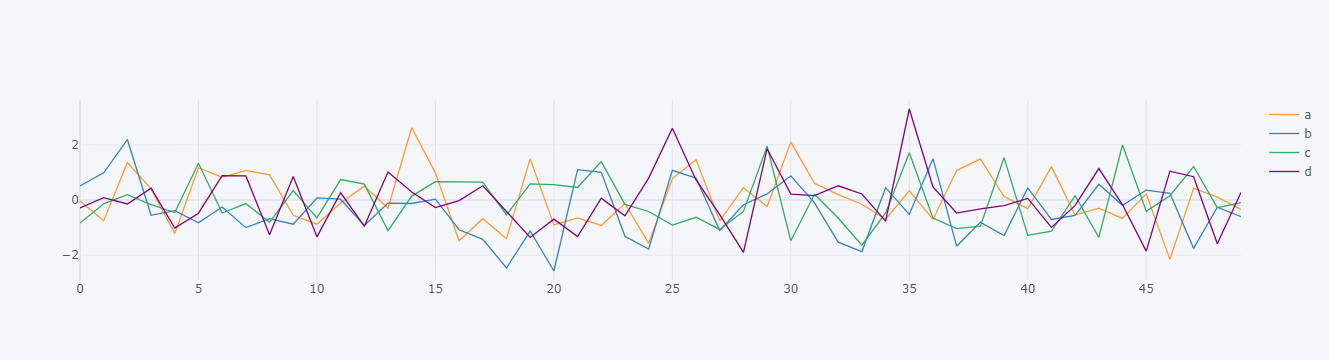

In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

arr_1 = np.random.randn(50,4)
df_1 = pd.DataFrame(arr_1, columns= ['a','b','c','d'])
df_1.iplot()